In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [2]:
def write_submission(forecast, path):
    df_out = pd.read_csv("sample_submission-2.csv")
    df_out.set_index("YEAR_MONTH", inplace = True)
    df_out['PASSENGERS CARRIED'] = forecast

    df_out.to_csv(path)
    

In [3]:
# importing data

df = pd.read_csv("AirtrafficA4.csv")

# dropping airline as there is just one airline

df.drop("AIRLINE", axis = 1, inplace = True)

removed = False

df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   YEAR                                    128 non-null    int64 
 1   MONTH                                   128 non-null    object
 2   TOTAL DEPARTURES                        127 non-null    object
 3   HOURS FLOWN                             127 non-null    object
 4   KILOMETRE FLOWN                         127 non-null    object
 5   PASSENGERS CARRIED                      127 non-null    object
 6   AVAILABLE SEAT KILOMETRE (IN THOUSAND)  127 non-null    object
 7    FREIGHT CARRIED (IN TONNE)             127 non-null    object
 8   MAIL CARRIED (IN TONNE)                 126 non-null    object
dtypes: int64(1), object(8)
memory usage: 9.1+ KB


In [4]:
if not(removed):
  col_rm_commas = list(df.columns)

  col_rm_commas.remove("YEAR")
  col_rm_commas.remove("MONTH")

  for attr in col_rm_commas:
    df[attr] = df[attr].str.replace(',', '').astype(float)
    # df[attr] = df[attr].bfill()
    df[attr] = df[attr].ffill()

  df_input = df.drop("PASSENGERS CARRIED", axis = 1)
  target = df["PASSENGERS CARRIED"]
  df.head()
  removed = True




df["MONTH"] = df["MONTH"].str.strip(" ")

In [5]:
month_mapping = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

# Map the month names to numbers
df['MONTH'] = df['MONTH'].replace({'JUNE': 'JUN', 'JULY': 'JUL'})
df['month_num'] = df['MONTH'].map(month_mapping)

# Sort by 'year' and 'month_num'
df = df.sort_values(['YEAR', 'month_num']).reset_index(drop=True)

# Add the 'time' column starting from 0
df['time'] = range(len(df))

# Drop the helper 'month_num' column if no longer needed
df = df.drop(columns='month_num')

df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + ' ' + df['MONTH'], format='%Y %b')
df.set_index('Date', inplace=True)





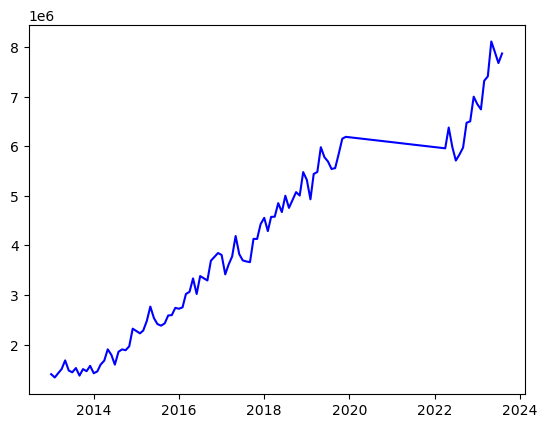

In [26]:

set_NAN = True
# Set the COVID months (2020 to 2022) values to NaN
if set_NAN:
    df.loc[((df.index.year >= 2020) & ((df.index.year < 2022))) , 'PASSENGERS CARRIED'] = np.nan
    df.loc[((df.index.year == 2022) & (df.index.month <= 3)) , 'PASSENGERS CARRIED'] = np.nan


    df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].interpolate()
    plt.plot(df['PASSENGERS CARRIED'], label='Historical Passengers', color='blue')


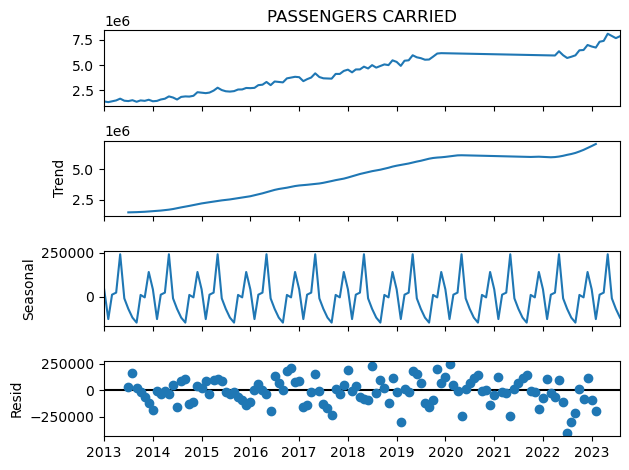

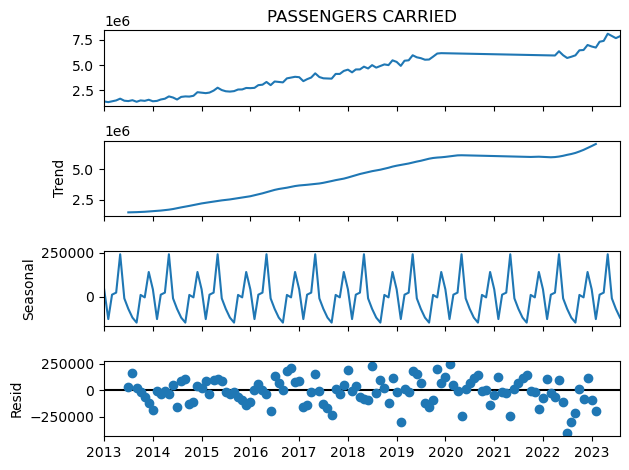

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['PASSENGERS CARRIED'], model='additive', period=12)  # Adjust `period` as needed
decomposition.plot()


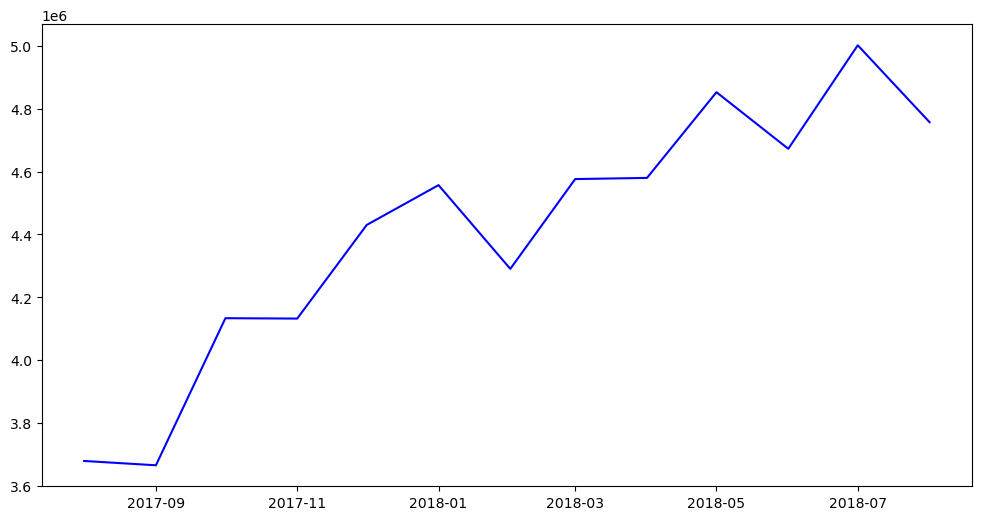

In [11]:
# Showing the seasonality between months

plt.figure(figsize=(12, 6))

plt.plot(df['PASSENGERS CARRIED'][-73:-60], label='Observed', color='blue')
plt.show()

# Naive Drift

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

train_data = df['PASSENGERS CARRIED']
n_periods = len(train_data) - 1


drift = (train_data.iloc[-1] - train_data.iloc[0]) / n_periods
nd_forecast = np.array([train_data.iloc[-1] + drift * i for i in range(1, 13)])
nd_forecast

array([7918119.21259843, 7968979.42519685, 8019839.63779528,
       8070699.8503937 , 8121560.06299213, 8172420.27559055,
       8223280.48818898, 8274140.7007874 , 8325000.91338583,
       8375861.12598425, 8426721.33858268, 8477581.5511811 ])

## ARIMA model


C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-09-01    7.932427e+06
2023-10-01    7.998837e+06
2023-11-01    8.064209e+06
2023-12-01    8.125041e+06
2024-01-01    8.189794e+06
2024-02-01    8.251161e+06
2024-03-01    8.315452e+06
2024-04-01    8.377218e+06
2024-05-01    8.441164e+06
2024-06-01    8.503227e+06
2024-07-01    8.566917e+06
2024-08-01    8.629202e+06
Freq: MS, Name: predicted_mean, dtype: float64


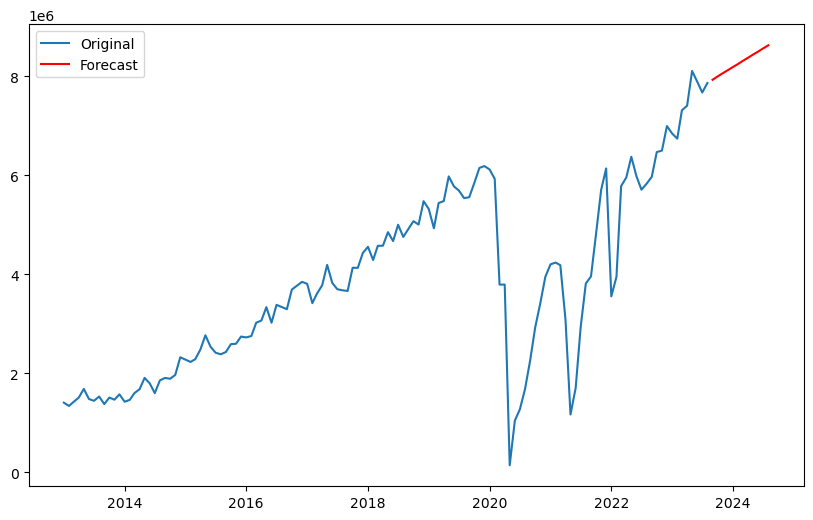

In [13]:
from statsmodels.tsa.arima.model import ARIMA

y = df['PASSENGERS CARRIED']
# ARIMA parameters
p = 1  
d = 2  
q = 4  

model = ARIMA(y, order=(p, d, q))
model_fit = model.fit()

forecast = model_fit.forecast(steps=12)
print(forecast)

# Plotting the forecasted values

plt.figure(figsize=(10, 6))
plt.plot(y, label='Original')
try:
    plt.plot(combined_forecast_df['Naive_Drift_Forecast'], label='Naive Drift Forecast', color='green', linestyle=':')
except:
    pass

plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()


In [14]:
from statsmodels.tsa.arima.model import ARIMA


# Subset the data to only include data before COVID
y = df['PASSENGERS CARRIED'].loc[:'2019-12-31']

# Define the range of p, d, q values for the grid search

p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Track best AIC and parameters

best_aic = np.inf
best_order = None
best_model = None

# Grid search

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(y, order=(p, d, q))
                model_fit = model.fit()
                
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Best ARIMA order: (1, 2, 2) with AIC: 2260.220681535387


C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


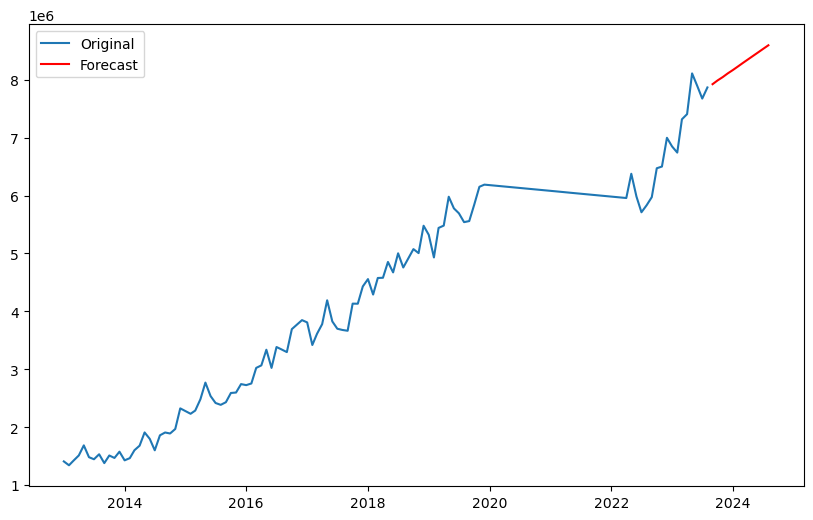

In [32]:
# Forecast using the best model found
best_model = ARIMA(df['PASSENGERS CARRIED'], order=best_order).fit()

forecast = best_model.forecast(steps=12)

# Plotting the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df['PASSENGERS CARRIED'], label='Original')
plt.plot(forecast.index, forecast, label='Forecast', color='red')

try:
    plt.plot(combined_forecast_df['Naive_Drift_Forecast'], label='Naive Drift Forecast', color='green', linestyle=':')
except:
    pass

plt.legend()
plt.show()


## Adding seasonality


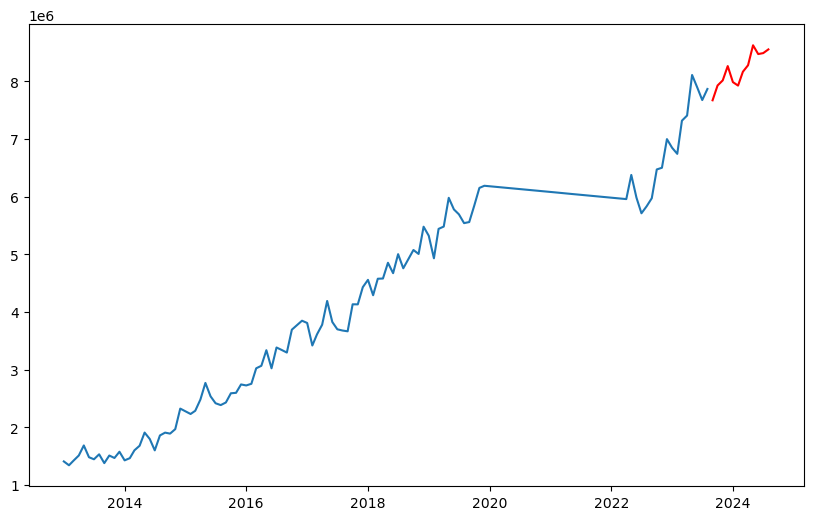

In [34]:
drift = (df['PASSENGERS CARRIED'].iloc[-1] - df['PASSENGERS CARRIED'].iloc[0]) / (len(df) - 1)

# We calculate the seasonaly effect to be applied 

seasonal_effect = df['PASSENGERS CARRIED'].groupby(df.index.month).mean()
sarray = np.array(seasonal_effect) - np.array(seasonal_effect).mean()

forecast_periods = 12  # Example forecast for 12 months
forecast_dates = pd.date_range(start='2023-09-01', periods=forecast_periods, freq='MS')

forecast_values = []
last_value = df['PASSENGERS CARRIED'].iloc[-1]

for i, forecast_date in enumerate(forecast_dates):

    drift_value = last_value + (i + 1) * drift
    
    seasonal_value = sarray[forecast_date.month - 1]
    forecast_value = drift_value + seasonal_value
    forecast_values.append(forecast_value)

# Create a forecast DataFrame
forecast_df = pd.DataFrame({'PASSENGERS CARRIED': forecast_values}, index=forecast_dates)
forecast_df
write_submission(list(forecast_df['PASSENGERS CARRIED']), 'submission.csv')
plt.figure(figsize=(10, 6))
plt.plot(df['PASSENGERS CARRIED'], label='Original')
plt.plot(forecast_df.index, forecast_df['PASSENGERS CARRIED'], label='Forecast', color='red')


## Fine tuned SARIMA

C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hars8\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[-329262.73161043134, -656879.2278702697, -247932.27943480015, -194656.50363955088, 230690.36708620843, 20461.138852416538, 54868.70452460926, -90731.26483338699, -36818.06140282843, 239485.64028496016, 415343.502085479, 595430.7159576034]


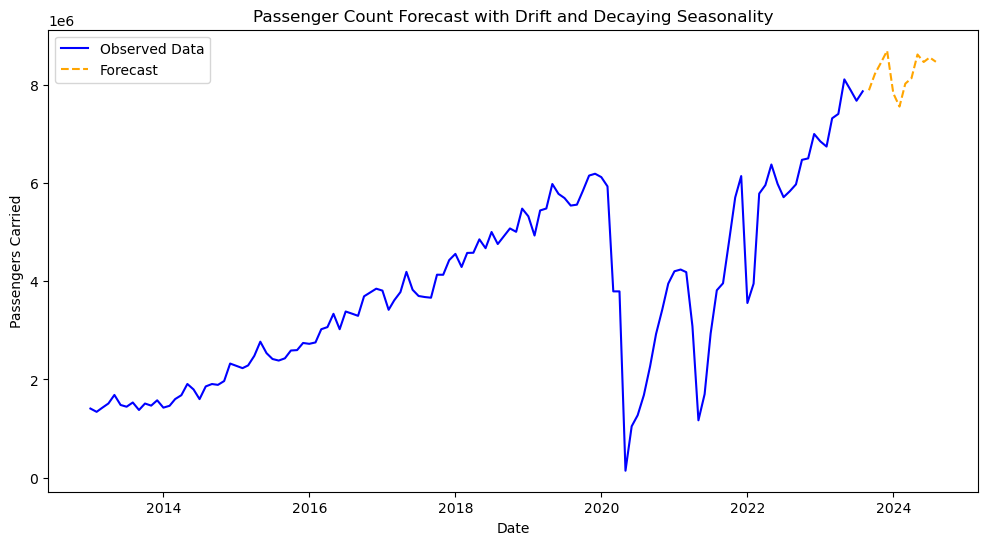

            PASSENGERS CARRIED
2023-09-01        7.888037e+06
2023-10-01        8.221936e+06
2023-11-01        8.455390e+06
2023-12-01        8.693073e+06
2024-01-01        7.825975e+06
2024-02-01        7.555954e+06
2024-03-01        8.022497e+06
2024-04-01        8.133368e+06
2024-05-01        8.616311e+06
2024-06-01        8.463677e+06
2024-07-01        8.555681e+06
2024-08-01        8.467676e+06


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
covid_start = '2019-12-01'
data = df
pre_covid_data = data[:covid_start]

drift = (pre_covid_data['PASSENGERS CARRIED'].iloc[-1] - pre_covid_data['PASSENGERS CARRIED'].iloc[0]) / (len(pre_covid_data) - 1)

train_data = pre_covid_data
sarima_model = SARIMAX(train_data['PASSENGERS CARRIED'], order=(0, 2, 1), seasonal_order=(0, 1, 1, 12))
sarima_results = sarima_model.fit()

forecast_steps = 12
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)

seasonal_adjustments = sarima_forecast.predicted_mean - sarima_forecast.predicted_mean.mean()
seasonal_offsets = (seasonal_adjustments.to_list())

print(seasonal_offsets)  

forecast_periods = 12 
forecast_dates = pd.date_range(start='2023-09-01', periods=forecast_periods, freq='MS')

# Initialize forecast with the last known value in the series
forecast_values = []
last_value = df['PASSENGERS CARRIED'].iloc[-1]

for i, forecast_date in enumerate(forecast_dates):
    drift_value = last_value + (i + 1) * drift
    seasonal_value = seasonal_offsets[forecast_date.month - 1]
    # Combine drift and seasonal component
    
#     print(drift_value, seasonal_value, forecast_date.month)
    
    
    forecast_value = drift_value + seasonal_value
    forecast_values.append(forecast_value)

# Create a forecast DataFrame
forecast_df = pd.DataFrame({'PASSENGERS CARRIED': forecast_values}, index=forecast_dates)


import matplotlib.pyplot as plt

# Plot the observed data
plt.figure(figsize=(12, 6))
plt.plot(df['PASSENGERS CARRIED'], label='Observed Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_df['PASSENGERS CARRIED'], label='Forecast', color='orange', linestyle='--')

# Add title and labels
plt.title("Passenger Count Forecast with Drift and Decaying Seasonality")
plt.xlabel("Date")
plt.ylabel("Passengers Carried")

# Show legend
plt.legend()

# Display the plot
plt.show()

write_submission(list(forecast_df['PASSENGERS CARRIED']), 'manual_decay.csv')
print(forecast_df)